In [1]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [2]:
img_rows = 224
img_cols = 224 

num_classes = 2

epochs = 3
batch_size = 30

train_data_size = 663
train_batch_size = 16
val_data_size = 87
val_batch_size = 8


train_path = '/content/drive/My Drive/dataset/train/'
val_path = '/content/drive/My Drive/dataset/test/'

train_step = train_data_size // batch_size
val_step = val_data_size // batch_size

In [3]:
model = VGG16(weights = 'imagenet', include_top = False, input_shape = (img_rows, img_cols, 3))

for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D True
2 Conv2D True
3 MaxPooling2D True
4 Conv2D True
5 Conv2D True
6 MaxPooling2D True
7 Conv2D True
8 Conv2D True
9 Conv2D True
10 MaxPooling2D True
11 Conv2D True
12 Conv2D True
13 Conv2D True
14 MaxPooling2D True
15 Conv2D True
16 Conv2D True
17 Conv2D True
18 MaxPooling2D True


In [4]:
for layer in model.layers:
    layer.trainable = False

for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [5]:
def addTop(bottom_model, num_classes):
    """creates the top or head of the model that will be placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation = "relu")(top_model)
    top_model = Dense(1024, activation = "relu")(top_model)
    top_model = Dense(512, activation = "relu")(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

In [6]:
FC_Head = addTop(model, num_classes)
new_model = Model(inputs=model.input, outputs=FC_Head)
print(new_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [7]:
train_data_gen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest')
val_data_gen = ImageDataGenerator(rescale=1./255) 

train_gen = train_data_gen.flow_from_directory(
    train_path, 
    target_size=(img_rows, img_cols), 
    batch_size=train_batch_size, 
    class_mode='categorical')
val_gen = val_data_gen.flow_from_directory(
    val_path, 
    target_size=(img_rows, img_cols), 
    batch_size=val_batch_size, 
    class_mode='categorical', 
    shuffle=False)

Found 663 images belonging to 2 classes.
Found 87 images belonging to 2 classes.


In [8]:
check_pt = ModelCheckpoint(
    "face.h5", 
    monitor="val_loss", 
    mode="min", 
    save_best_only = True, 
    verbose=1)
earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0, 
    patience = 3, 
    verbose = 1, 
    restore_best_weights = True)

callbacks = [earlystop, check_pt]

new_model.compile(
    loss = 'categorical_crossentropy', 
    optimizer = RMSprop(lr = 0.001), 
    metrics = ['accuracy'])

In [9]:
history = new_model.fit(
    train_gen, 
    steps_per_epoch = train_step, 
    epochs = epochs, 
    callbacks = callbacks, 
    validation_data = val_gen, 
    validation_steps = val_step
)
new_model.save("face.h5")

Epoch 1/3
22/22 [==============================] - 176s 8s/step - loss: 0.7151 - accuracy: 0.7812 - val_loss: 0.1060 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.10600, saving model to face.h5
Epoch 2/3
22/22 [==============================] - 143s 7s/step - loss: 0.1980 - accuracy: 0.9271 - val_loss: 0.0027 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.10600 to 0.00271, saving model to face.h5
Epoch 3/3
22/22 [==============================] - 8s 380ms/step - loss: 0.1829 - accuracy: 0.9592 - val_loss: 0.0909 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00271


In [10]:
dir_indx = train_gen.class_indices
print(dir_indx)

{'modi': 0, 'sahil': 1}


In [11]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

model = load_model('face.h5')
image1 = image.load_img('me.jpg')
image2 = image1.resize((224,224))
test_img = image.img_to_array(image2)
test_img = np.expand_dims(test_img, axis=0)

out = model.predict(test_img)

index = 0
for i in out[0]:
  if i==0:
    index=0
    break
  elif i==1:
    index=1
list(dir_indx.keys())[index]

'sahil'

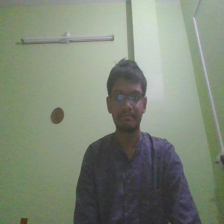

In [12]:
image2